In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
y_train.shape

(60000,)

In [7]:
# Assuming imgs has the shape (batch_size, height, width)

# First Dimension (Batch Dimension):
# 0 padding before the first dimension (batch dimension).
# 0 padding after the first dimension (batch dimension).
# This means no padding is added to the batch dimension.
# Specified as (0, 0).

# Second Dimension (Height Dimension):
# 2 padding before the second dimension (height dimension).
# 2 padding after the second dimension (height dimension).
# This means a total of 4 pixels (2 before and 2 after) will be added to the height of each image.
# Specified as (2, 2).

# Third Dimension (Width Dimension):
# 2 padding before the third dimension (width dimension).
# 2 padding after the third dimension (width dimension).
# This means a total of 4 pixels (2 before and 2 after) will be added to the width of each image.
# Specified as (2, 2).

# Before padding:
# +----------------------------+
# |                            |
# |                            |
# |                            |
# |                            |
# |                            |
# |                            |
# +----------------------------+

# After padding:
# +--------------------------------+
# |          (2,2)                 |
# |  +--------------------------+  |
# |  |                          |  |
# |  |                          |  |
# |  |                          |  |
# |  |                          |  |
# |  |                          |  |
# |  |                          |  |
# |  +--------------------------+  |
# |          (2,2)                 |
# +--------------------------------+

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

Autoencoder model

In [8]:
# encoder
encoder_input = layers.Input(
    shape=(32, 32, 1), name="encoder_input"
)

# conv2D layer
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# decoder
decoder_input = layers.Input(
    shape=(2, ), name="decoder_input"
)

# convert back to flatten layer, (4 * 4 * 128) = 2048
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

# reshape 2048 to (4 * 4 * 128), then feed to Conv2DTranspose layer
x = layers.Reshape(shape_before_flattening)(x)

# 128 channel to 64
x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
# 64 channel to 32
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)
# 32 channel to 1
x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(filters=1,kernel_size=(3, 3),strides=1,activation="sigmoid",padding="same",name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Join encoder and decoder together

In [10]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - loss: 0.3657 - val_loss: 0.2639
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.2601 - val_loss: 0.2583
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - loss: 0.2560 - val_loss: 0.2551
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - loss: 0.2529 - val_loss: 0.2535
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - loss: 0.2515 - val_loss: 0.2519


In [13]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [14]:
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[1.92045874e-07],
         [1.29169884e-08],
         [2.80145002e-07],
         ...,
         [9.08721454e-09],
         [1.41864822e-08],
         [4.85845112e-06]],

        [[1.52253832e-09],
         [1.48302190e-10],
         [1.20864119e-08],
         ...,
         [1.85766635e-09],
         [8.46739956e-10],
         [1.87664597e-07]],

        [[2.65502358e-08],
         [5.17287235e-09],
         [5.51119285e-07],
         ...,
         [3.40614224e-06],
         [1.49089146e-07],
         [2.20972720e-06]],

        ...,

        [[1.98226192e-11],
         [2.13436942e-11],
         [9.36720937e-07],
         ...,
         [1.06783773e-07],
         [8.20036039e-10],
         [2.47443381e-07]],

        [[7.22613080e-10],
         [4.13432899e-11],
         [3.07850705e-08],
         ...,
         [8.90915230e-10],
         [2.13374762e-10],
         [1.90888201e-07]],

        [[5.60297167e-06],
         [4.34784198e-07],
         [3.29074760e-06],
         ...,
 

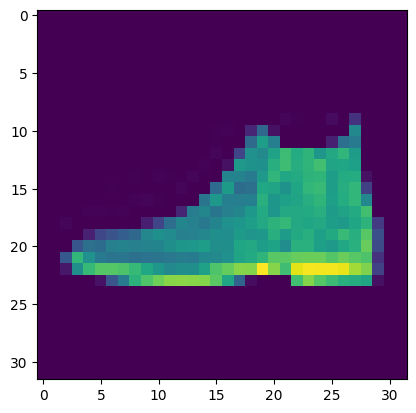

In [15]:
plt.imshow(example_images[0])

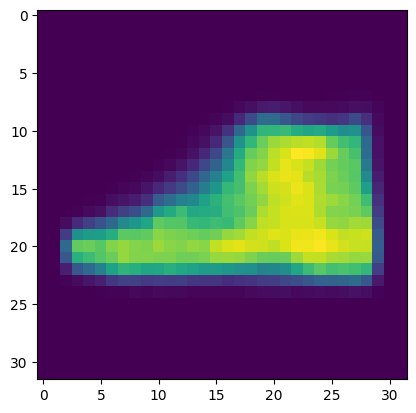

In [16]:
plt.imshow(predictions[0])